# Titanic Light GBM



### Imports

In [1]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

### Data Download

In [2]:
data_dir = Path('../../dacon-inputs/titanic/input')
sub_dir = Path('../../dacon-inputs/titanic/sub')
feature_dir = Path('../../dacon-inputs/titanic/feature')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'submission.csv'
feature_file = feature_dir / 'numerical_features.csv'
seed = 42

In [3]:
data_dir.resolve()

WindowsPath('C:/Users/bryan/dacon-inputs/titanic/input')

### Light GBM

In [4]:
target_col = 'Survived'

In [5]:
algo_name = 'lgb'
feature_name = 'numerical_features'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(1309, 6)


,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,0.0,3,22.0,1,0,7.2500
2,1.0,1,38.0,1,0,71.2833
3,1.0,3,26.0,0,0,7.9250
4,1.0,1,35.0,1,0,53.1000
5,0.0,3,35.0,0,0,8.0500


In [7]:
# Split Train/Test Data
y = df[target_col].values[:891]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:891]
tst = df.iloc[891:]
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(891,) (891, 5) (418, 5)


In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(712, 5) (179, 5) (712,) (179,)


In [12]:
# Train LightGBM Classifier
clf = lgb.LGBMClassifier(objective='binary', # survived: 0 or 1
                         learning_rate=0.003,
                         sub_feature=0.5,
                         num_leaves=10, # default는 훨씬 크지만, 작은 데이터 세트이기 때문에
                         min_child_samples = 50,
                         max_depth = 10
                        )

clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss', # binary classification
        early_stopping_rounds=10)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

[1]	valid_0's binary_logloss: 0.680328
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.679895
[3]	valid_0's binary_logloss: 0.679372
[4]	valid_0's binary_logloss: 0.678803
[5]	valid_0's binary_logloss: 0.678266
[6]	valid_0's binary_logloss: 0.677651
[7]	valid_0's binary_logloss: 0.67714
[8]	valid_0's binary_logloss: 0.676903
[9]	valid_0's binary_logloss: 0.676297
[10]	valid_0's binary_logloss: 0.67588
[11]	valid_0's binary_logloss: 0.67535
[12]	valid_0's binary_logloss: 0.674939
[13]	valid_0's binary_logloss: 0.674421
[14]	valid_0's binary_logloss: 0.674014
[15]	valid_0's binary_logloss: 0.673507
[16]	valid_0's binary_logloss: 0.672968
[17]	valid_0's binary_logloss: 0.672383
[18]	valid_0's binary_logloss: 0.671802
[19]	valid_0's binary_logloss: 0.671398
[20]	valid_0's binary_logloss: 0.671002
[21]	valid_0's binary_logloss: 0.670505
[22]	valid_0's binary_logloss: 0.670114
[23]	valid_0's binary_logloss: 0.669616
[24]	valid_0's binary_logloss: 

In [13]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

58.6592%


Very low accuracy: probably because dataset is too small (overfitting)

<AxesSubplot:ylabel='feature'>

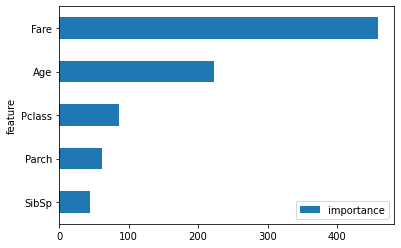

In [14]:
# Visualize Feature Importance
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [15]:
# Create Submission File
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(418, 1)


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [16]:
sub[target_col] = p_tst
sub.head()

,Survived
PassengerId,
892,0.0
893,0.0
894,0.0
895,0.0
896,0.0


In [17]:
sub[target_col].value_counts()

0.0    418
Name: Survived, dtype: int64

In [18]:
# Saving Submission File
sub.to_csv(sub_file)